In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

from subprocess import check_output
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [24]:
"""Read the csv file"""
df = pd.read_csv('gtcap.csv')
df['Price'] = df['Price'].replace(',', '', regex=True)
df['Price'] = df['Price'].apply(pd.to_numeric)

In [25]:
prices = df.Price.values.astype('float32')
prices = prices.reshape(1701, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(prices)
prices.shape

(1701, 1)

In [4]:
train_size = int(len(prices) * 0.90)
test_size = len(prices) - train_size
train, test = prices[0:train_size, :], prices[train_size:len(prices), :]
print(len(train), len(test))

1530 171


In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i: (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

`Three-layared LSTM model with 0.2 dropout`

In [8]:
model = Sequential()

model.add(LSTM(units=50, input_dim=7, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 50)          11600     
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [10]:
model.fit(x = trainX, y = trainY, batch_size = 32, epochs = 100)

Epoch 1/100
48/48 [==============================] - 5s 8ms/step - loss: 0.2717
Epoch 2/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0151
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 4/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 5/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 6/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 7/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 8/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 9/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 10/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 11/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0046
Epoch 12/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 13/100
48/48 [=================

In [11]:
prediction = model.predict(testX)
prediction = scaler.inverse_transform(np.array(prediction).reshape(-1, 1))
actual = scaler.inverse_transform(np.array(testY).reshape(-1, 1))

In [12]:
prediction = [x[0] for x in prediction.tolist()]
actual = [x[0] for x in actual.tolist()]

In [40]:
index1 = [len(train) + x for x in range(len(test - 8))][:-8]


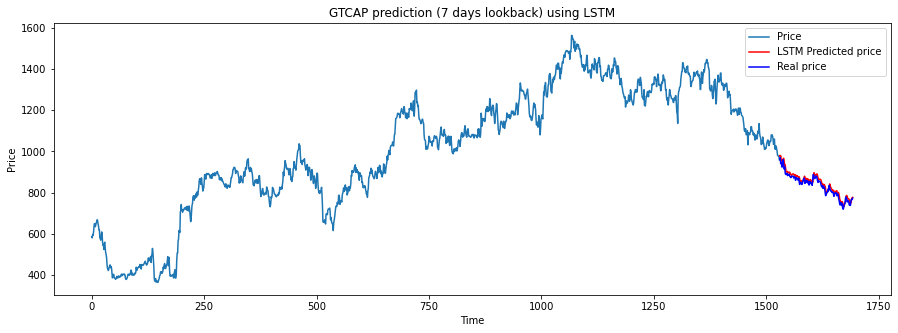

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
df['Price'][:train_size].plot(ax=ax, legend=False)
plt.plot(index1, prediction, color = 'red', label = 'LSTM Predicted price')
plt.plot(index1, actual, color = 'blue', label = 'Real price')
ax.set_title('GTCAP prediction (7 days lookback) using LSTM')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.autoscale()
ax.legend()
plt.show()

In [14]:
def mae(y_true, y_pred):
    score = np.mean(np.abs(y_true - y_pred))
    return score

def rmse(y_true, y_pred):
    score = np.sqrt(np.mean((y_true - y_pred)**2))
    return score

In [15]:
ac_pred = [actual, prediction]

ac_pred1 = np.asarray(ac_pred, dtype=np.float32)

cols = ['Deep Learning Method', 'Mean Absolute Error', 'Root Mean Squared Error']
df_metrics1 = pd.DataFrame(columns=cols)
df_metrics1.loc[0] = ['LSTM', mae(ac_pred1[0], ac_pred1[1]),
                      rmse(ac_pred1[0], ac_pred1[1])]
df_metrics1

,Deep Learning Method,Mean Absolute Error,Root Mean Squared Error
0,LSTM,13.239486,15.863252
